<a href="https://colab.research.google.com/github/majd2003omari/loan_stuat_project/blob/main/pipline_project_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# load data

In [ ]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "loan_data.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "udaymalviya/bank-loan-data",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

print("First 5 records:", df.head())

/tmp/ipython-input-3377227115.py:10: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


100%|██████████| 3.44M/3.44M [00:00<00:00, 40.0MB/s]


First 5 records:    person_age person_gender person_education  person_income  person_emp_exp  \
0        22.0        female           Master        71948.0               0   
1        21.0        female      High School        12282.0               0   
2        25.0        female      High School        12438.0               3   
3        23.0        female         Bachelor        79753.0               0   
4        24.0          male           Master        66135.0               1   

  person_home_ownership  loan_amnt loan_intent  loan_int_rate  \
0                  RENT    35000.0    PERSONAL          16.02   
1                   OWN     1000.0   EDUCATION          11.14   
2              MORTGAGE     5500.0     MEDICAL          12.87   
3                  RENT    35000.0     MEDICAL          15.23   
4                  RENT    35000.0     MEDICAL          14.27   

   loan_percent_income  cb_person_cred_hist_length  credit_score  \
0                 0.49                         3.

In [ ]:
df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [ ]:
df.columns

Index(['person_age', 'person_gender', 'person_education', 'person_income',
       'person_emp_exp', 'person_home_ownership', 'loan_amnt', 'loan_intent',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
       'credit_score', 'previous_loan_defaults_on_file', 'loan_status'],
      dtype='object')

## Drop to some columns because it does not need in pipeline

In [ ]:
df=df[["loan_amnt","person_income","loan_intent","previous_loan_defaults_on_file",'loan_int_rate','person_home_ownership','person_age','loan_status']]

In [ ]:
len(df.columns)

8

# functions

In [ ]:
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import pandas as pd
from sklearn.ensemble import IsolationForest

In [ ]:
def outlier(df):
    import pandas as pd
    from sklearn.ensemble import IsolationForest
    df_copy = df.copy()

    # Correctly select numerical columns
    numeric_cols_for_outlier = df_copy.select_dtypes(include=['number']).columns

    if numeric_cols_for_outlier.empty:
        return df_copy

    iso_forest = IsolationForest(contamination=0.01, random_state=42)
    iso_forest.fit(df_copy[numeric_cols_for_outlier])
    iso_preds = iso_forest.predict(df_copy[numeric_cols_for_outlier])

    for col in numeric_cols_for_outlier:
        df_copy.loc[iso_preds == -1, col] = pd.NA
    return df_copy


In [ ]:

def feature_engineering(df):

    intent_risk_map = {
        "DEBTCONSOLIDATION": 0.302729,
        "MEDICAL": 0.278194,
        "HOMEIMPROVEMENT": 0.263015,
        "PERSONAL": 0.201404,
        "EDUCATION": 0.169562,
        "VENTURE": 0.144264  }
    df["age_group"] = pd.cut(
        df["person_age"],
        bins=[17, 25, 35, 45, 55, 100],
        labels=["18-25", "26-35", "36-45", "46-55", "56+"]
    )
    df["debt_to_income"] = df["loan_amnt"] / df["person_income"]
    df["monthly_income"] = df["person_income"] / 12
    df["intent_risk_score"] = df["loan_intent"].map(intent_risk_map)
    df["prev_default_flag"] = df["previous_loan_defaults_on_file"].map({"Yes": 1, "No": 0})
    df["loan_to_month_income"] = df["loan_amnt"] / df["monthly_income"]

    df["loan_percent_income"] = df["loan_amnt"] / df["person_income"]


    df["loan_risk_score"] = df["loan_int_rate"] * df["loan_percent_income"]
    df = df.drop(columns=["previous_loan_defaults_on_file"])
    return df

def drop_unwanted_columns(df):
    return df[retained_columns]



### Feature Engineering & Outlier Handling

## 1. Outlier Handling (`outlier` function)
- Detects outliers in numerical columns using `IsolationForest`.
- Outliers are identified with a contamination rate of 1%.
- Values in detected outlier rows are replaced with `pd.NA` for further imputation.
- Ensures that extreme values do not negatively impact model training.

## 2. Feature Engineering (`feature_engineering` function)
- Generates derived features from the original dataset:
    - `age_group`: categorizes age into intervals (18-25, 26-35, 36-45, 46-55, 56+)
    - `debt_to_income`: loan amount divided by total income
    - `monthly_income`: annual income divided by 12
    - `intent_risk_score`: risk score mapped from loan intent
    - `prev_default_flag`: converts previous defaults (Yes/No) to 1/0
    - `loan_to_month_income`, `loan_percent_income`, `loan_risk_score`: additional financial metrics
- Drops the original `previous_loan_defaults_on_file` column after conversion.
- Prepares data for the model with meaningful numeric and categorical features.



# Model selection

In [ ]:
import pandas as pd
import joblib

# Install scikeras if not already installed
try:
    import scikeras
except ImportError:
    !pip install scikeras
    import scikeras

model_ml= joblib.load('/content/drive/MyDrive/Colab Notebooks/ملفات الكولاب /best_loan_stutes_model_without_ft.pkl')
result=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ملفات الكولاب /random_forest_finetuned_results.csv')


model_deep= joblib.load('/content/drive/MyDrive/Colab Notebooks/ملفات الكولاب /best_loan_stutes_model_DEEP_LEARNING_final.pkl')
result_deep=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ملفات الكولاب /validation_metrics.csv')

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator OrdinalEncoder from version 1.8.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.8.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator FunctionTransformer from version 1.8.0 when using version 1.6.1. This might lead to breaking code or i

In [ ]:
print("------comparison------")
print("Random forest")
print(result)
print("Deep learning")
print(result_deep)


------comparison------
Random forest
           Model  Accuracy  Precision    Recall        F1       AUC  \
0  Random Forest  0.946839   0.937031  0.958071  0.947431  0.946839   

   Specificity  
0     0.935607  
Deep learning
        Metric  Mean Value
0     Accuracy    0.902607
1    Precision    0.881389
2       Recall    0.930607
3     F1-score    0.905246
4  Specificity    0.874607
5      ROC-AUC    0.972490


##  Loan Repayment Prediction (Will the customer repay the loan?)

The objective of this system is to **predict whether a customer will repay the loan or not**. In this context, it is important to correctly identify **customers who will NOT repay**, in order to avoid granting loans to unreliable borrowers.

###  Random Forest Model

The Random Forest model achieved strong performance across all evaluation metrics. It recorded a **high accuracy (94.68%)**, indicating reliable overall predictions. The model also showed a **high recall (95.81%)**, meaning it successfully identified most customers who did not repay their loans. In addition, the model achieved a **high specificity (93.56%)**, which reflects its ability to correctly recognize customers who will repay their loans.

This balanced performance makes the Random Forest model reliable in distinguishing between customers who repay and those who do not.

### Deep Learning Model

The Deep Learning model achieved a very high **ROC-AUC score (97.25%)**, showing strong discrimination between the two classes. However, its **specificity (87.46%)** and **precision (88.14%)** were lower compared to the Random Forest model. This indicates that the model is more likely to misclassify some customers who will not repay the loan as reliable payers.

### Final Decision

Although the Deep Learning model shows strong classification ability, the **Random Forest model was selected as the final model** because it provides **more stable and reliable predictions**, especially in correctly identifying customers’ repayment behavior.


# pipline

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer, OneHotEncoder, FunctionTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import mutual_info_classif, RFE
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.preprocessing import FunctionTransformer

initial_numerical = [
    "person_age",
    "loan_amnt",
    "person_income",
    "loan_int_rate",
]


numerical_cols= [
    "loan_amnt",
    "person_income",
    "loan_int_rate",
    "debt_to_income",
    "monthly_income",
    "intent_risk_score",
    "prev_default_flag",
    "loan_to_month_income",
    "loan_percent_income",
    "loan_risk_score",
]

categorical_cols= [
    'person_home_ownership',
    'loan_intent',
    'age_group'
]


initial_categorical= [
    'person_home_ownership',
    'loan_intent',
    "previous_loan_defaults_on_file"
    ]


retained_columns = numerical_cols+[
    "age_group_18-25",
    "age_group_26-35",
    "loan_intent_MEDICAL",
    "loan_intent_EDUCATION",
    "loan_intent_HOMEIMPROVEMENT",
    "loan_intent_VENTURE",
    "loan_intent_DEBTCONSOLIDATION",
    "person_home_ownership_RENT",
    "person_home_ownership_MORTGAGE",
    "person_home_ownership_OWN"
]


drop_columns_transformer = FunctionTransformer(drop_unwanted_columns, validate=False)



In [ ]:
numerical_imputation_pipeline = Pipeline([
    ('handle_missing_', IterativeImputer(random_state=42, max_iter=10)),
    ('handle_outliers', FunctionTransformer(outlier, validate=False)),
    ('handle_missing_values', IterativeImputer(random_state=42, max_iter=10))
])


initial_preprocessing_ct = ColumnTransformer(
    [('num_initial_prep', numerical_imputation_pipeline, initial_numerical),
     ('cat_initial_prep',SimpleImputer(strategy='most_frequent'),initial_categorical)
     ],
    remainder='passthrough',verbose_feature_names_out=False
    ).set_output(transform="pandas")

# Define explicit categories for OneHotEncoder to ensure consistent columns
home_ownership_categories = ['MORTGAGE', 'OWN', 'RENT']
loan_intent_categories = ['DEBTCONSOLIDATION', 'EDUCATION', 'HOMEIMPROVEMENT', 'MEDICAL', 'PERSONAL', 'VENTURE']
age_group_categories = ["18-25", "26-35", "36-45", "46-55", "56+"]

final_preprocessing= ColumnTransformer([
        ('num',  PowerTransformer(method='yeo-johnson'), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False,
                              categories=[home_ownership_categories, loan_intent_categories, age_group_categories]), categorical_cols)
], verbose_feature_names_out=False).set_output(transform="pandas")
pipe = ImbPipeline([
    ('initial_preprocessing', initial_preprocessing_ct),
    ('feature_engineering', FunctionTransformer(feature_engineering, validate=False).set_output(transform="pandas")),
    ('final_preprocessing', final_preprocessing),
    ('drop_encoded_columns', drop_columns_transformer),
    ('smote', SMOTE(random_state=42,k_neighbors=5)),
    ('model', model_ml)
])

x = df.drop(columns=['loan_status']).copy()
y = df['loan_status']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42,stratify=y)
pipe.fit(x_train,y_train)


Pipeline(steps=[('initial_preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_initial_prep',
                                                  Pipeline(steps=[('handle_missing_',
                                                                   IterativeImputer(random_state=42)),
                                                                  ('handle_outliers',
                                                                   FunctionTransformer(func=<function outlier at 0x7ddf284c49a0>)),
                                                                  ('handle_missing_values',
                                                                   IterativeImputer(random_state=42))]),
                                                  ['person_age', 'loan_a...
                                                                            ['18-25',
                                                                             '26-35',
                                                                             '36-45',
                                                                             '46-55',
                                                                             '56+']],
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['person_home_ownership',
                                                   'loan_intent',
                                                   'age_group'])],
                                   verbose_feature_names_out=False)),
                ('drop_encoded_columns',
                 FunctionTransformer(func=<function drop_unwanted_columns at 0x7ddf284c5120>)),
                ('smote', SMOTE(random_state=42)),
                ('model', RandomForestClassifier(random_state=42))])

In [ ]:
predictions = pipe.predict( x_test)
print(predictions[:10])


[0 0 0 0 1 1 0 0 0 1]


### Pipeline Explanation

## 1. Initial Preprocessing

**Numerical Imputation:** Missing values in numerical columns are handled using `IterativeImputer`, followed by outlier handling using `FunctionTransformer` with the `outlier` function.

**Categorical Imputation:** Missing values in categorical columns are filled using `SimpleImputer` with the most frequent strategy.

---

## 2. Feature Engineering

The `feature_engineering` function is applied to the data to generate derived columns such as `loan_percent_income`, `debt_to_income`, `monthly_income`, and others.

---

## 3. Final Preprocessing

**Numerical Transformation:** `PowerTransformer` is applied to numerical features to stabilize variance and improve distribution.

**Categorical Transformation:** Categorical features are converted into dummy/one-hot encoded variables using `OneHotEncoder`.

---

## 4. Handling Imbalanced Data (SMOTE)

`SMOTE` is used to balance the classes in the target variable, which helps improve model performance.

---

## 5. Model

Finally, a `RandomForestClassifier` is applied to the processed data for prediction.


# GRID SEARCHE & CROSS VALIDATION

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'model__n_estimators': [300,400,500,600],
    'model__max_depth': [15,20,25,30,40],
    'model__min_samples_split': [2, 5, 10]
}

grid = GridSearchCV(pipe, param_grid, cv=5, scoring='f1')

grid.fit(x_train, y_train)
print("Best Parameters:", grid.best_params_)
print("Best Score:", grid.best_score_)


Best Parameters: {'model__max_depth': 40, 'model__min_samples_split': 2, 'model__n_estimators': 500}
Best Score: 0.823589203416628


In [ ]:
import pandas as pd
results_df = pd.DataFrame(grid.cv_results_)
results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__max_depth,param_model__min_samples_split,param_model__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,27.078507,0.688238,0.581586,0.074821,15,2,300,"{'model__max_depth': 15, 'model__min_samples_s...",0.808559,0.811553,0.811670,0.817247,0.804751,0.810756,0.004111,51
1,35.117885,0.574928,0.668640,0.106518,15,2,400,"{'model__max_depth': 15, 'model__min_samples_s...",0.806838,0.808924,0.811561,0.815385,0.804052,0.809352,0.003895,60
2,43.743280,0.389135,0.704146,0.094743,15,2,500,"{'model__max_depth': 15, 'model__min_samples_s...",0.808899,0.809619,0.810639,0.815977,0.802899,0.809607,0.004175,59
3,52.862264,0.981960,0.735053,0.017898,15,2,600,"{'model__max_depth': 15, 'model__min_samples_s...",0.809592,0.809742,0.810295,0.815407,0.803597,0.809727,0.003746,57
4,26.487493,0.196632,0.517776,0.012127,15,5,300,"{'model__max_depth': 15, 'model__min_samples_s...",0.811660,0.810981,0.813765,0.813781,0.804970,0.811031,0.003230,49
5,35.243129,0.663239,0.616439,0.069723,15,5,400,"{'model__max_depth': 15, 'model__min_samples_s...",0.811553,0.809483,0.812104,0.815722,0.804618,0.810696,0.003644,52
6,44.476120,0.878622,0.710261,0.083556,15,5,500,"{'model__max_depth': 15, 'model__min_samples_s...",0.812482,0.809021,0.813276,0.814709,0.805315,0.810961,0.003387,50
7,51.836132,0.687302,0.814900,0.133166,15,5,600,"{'model__max_depth': 15, 'model__min_samples_s...",0.811429,0.810857,0.812806,0.814920,0.802772,0.810557,0.004136,53
8,27.725522,2.550861,0.509056,0.010516,15,10,300,"{'model__max_depth': 15, 'model__min_samples_s...",0.809361,0.810271,0.810608,0.813068,0.806601,0.809982,0.002089,56
9,35.083521,1.172691,0.673912,0.095595,15,10,400,"{'model__max_depth': 15, 'model__min_samples_s...",0.808098,0.812073,0.810017,0.814920,0.807648,0.810551,0.002688,54


## Best Parameters: {'model__max_depth': 40, 'model__min_samples_split': 2, 'model__n_estimators': 500}
## Best Score: 0.823589203416628

# THE RESULT GRIDE SEARCH ON CROSS VALIDATION

In [ ]:
best_model = grid.best_estimator_

In [ ]:
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.metrics import specificity_score
import pandas as pd

# Define scoring metrics for CV
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score),
    'specificity': make_scorer(specificity_score)
}

# Define skf again as it was not defined in this cell's execution context
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation on the best model
cv_results = cross_validate(
    best_model,
    x_train,
    y_train,
    cv=skf,  # same StratifiedKFold
    scoring=scoring,
    return_train_score=False
)

# Aggregate results
cv_summary = {
    "Accuracy": cv_results['test_accuracy'].mean(),
    "Precision": cv_results['test_precision'].mean(),
    "Recall": cv_results['test_recall'].mean(),
    "F1": cv_results['test_f1'].mean(),
    "AUC": cv_results['test_roc_auc'].mean(),
    "Specificity": cv_results['test_specificity'].mean()
}

# Display all metrics as a dataframe
pd.DataFrame([cv_summary])

,Accuracy,Precision,Recall,F1,AUC,Specificity
0,0.917583,0.789096,0.858625,0.822388,0.896527,0.934429


# THE RESULT CROSS VALIDATION WITHOUT GRIDE SEARCH

In [ ]:
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.metrics import specificity_score
import pandas as pd

# Define scoring metrics for CV
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score),
    'specificity': make_scorer(specificity_score)
}

# Define skf again as it was not defined in this cell's execution context
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation on the best model
cv_results = cross_validate(
    pipe, # Use the full pipeline here, not just RandomForestClassifier
    x_train,
    y_train,
    cv=skf,  # same StratifiedKFold
    scoring=scoring,
    return_train_score=False
)

# Aggregate results
cv_summary = {
    "Accuracy": cv_results['test_accuracy'].mean(),
    "Precision": cv_results['test_precision'].mean(),
    "Recall": cv_results['test_recall'].mean(),
    "F1": cv_results['test_f1'].mean(),
    "AUC": cv_results['test_roc_auc'].mean(),
    "Specificity": cv_results['test_specificity'].mean()
}

# Display all metrics as a dataframe
pd.DataFrame([cv_summary])

,Accuracy,Precision,Recall,F1,AUC,Specificity
0,0.918278,0.791505,0.858375,0.823574,0.896884,0.935393


# COMPARISION

In [ ]:
import pandas as pd

comparison_df = pd.DataFrame({
    "Model": [
        "With Grid Search (CV)",
        "Without Grid Search (CV)"
    ],
    "Accuracy": [0.917583, 0.918278],
    "Precision": [0.789096, 0.791505],
    "Recall": [0.858625, 0.858375],
    "F1-score": [0.822388, 0.823574],
    "AUC": [0.896527, 0.896884],
    "Specificity": [0.93442, 0.93539]
})

comparison_df


,Model,Accuracy,Precision,Recall,F1-score,AUC,Specificity
0,With Grid Search (CV),0.917583,0.789096,0.858625,0.822388,0.896527,0.93442
1,Without Grid Search (CV),0.918278,0.791505,0.858375,0.823574,0.896884,0.93539


## Model Selection Justification

Two models were evaluated using stratified cross-validation: one with hyperparameter tuning using GridSearchCV and one without hyperparameter tuning.

The results show that both models achieved very similar performance across all evaluation metrics. However, the model without Grid Search slightly outperformed the tuned model in terms of F1-score, AUC, and most importantly, specificity.

Since the problem prioritizes correctly identifying negative cases and minimizing false positives, specificity was considered a key metric in model selection.

Therefore, the model without Grid Search was selected as the final model, as it better aligns with the problem requirements while maintaining stable and balanced overall performance.

# IMPORTANT NOTES


In [ ]:
import pandas as pd

comparison_df = pd.DataFrame({
    "Model": [
        "Random Forest (Old Model)",
        "Pipeline Random Forest (CV)"
    ],
    "Accuracy": [0.946839, 0.918278],
    "Precision": [0.937031, 0.791505],
    "Recall": [0.958071, 0.858375],
    "F1-score": [0.947431, 0.823574],
    "AUC": [0.946839, 0.896884],
    "Specificity": [0.935607, 0.93539]
})

comparison_df


,Model,Accuracy,Precision,Recall,F1-score,AUC,Specificity
0,Random Forest (Old Model),0.946839,0.937031,0.958071,0.947431,0.946839,0.935607
1,Pipeline Random Forest (CV),0.918278,0.791505,0.858375,0.823574,0.896884,0.935390


## Pipeline vs Old Model Performance Analysis

A noticeable difference can be observed between the performance of the old Random Forest model and the pipeline-based model evaluated using cross-validation.

The old model achieved higher performance metrics; however, these results were obtained without applying preprocessing steps within a pipeline. As a result, data preprocessing (such as encoding and scaling) was performed on the entire dataset before model evaluation, which led to data leakage.

This data leakage allowed information from the validation folds to unintentionally influence the training process, producing overly optimistic performance results.

In contrast, the pipeline-based model applies all preprocessing steps correctly within each fold during cross-validation. Although this resulted in slightly lower performance metrics, the evaluation is more realistic, unbiased, and reliable.

Therefore, the pipeline model’s results better reflect the true generalization ability of the model and are considered more trustworthy for real-world deployment.

#  EVALUATION PIPLINE MODEL

In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve
)

from imblearn.metrics import specificity_score


# Generate predictions and probabilities using the full pipeline
y_pred = pipe.predict(x_test)
y_proba = pipe.predict_proba(x_test)[:, 1]

# Collect main metrics
final_results = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1": f1_score(y_test, y_pred),
    "AUC": roc_auc_score(y_test, y_proba),
    "specificity": specificity_score(y_test, y_pred)
}

pd.DataFrame([final_results])

,Accuracy,Precision,Recall,F1,AUC,specificity
0,0.918444,0.787466,0.867,0.825321,0.974463,0.933143


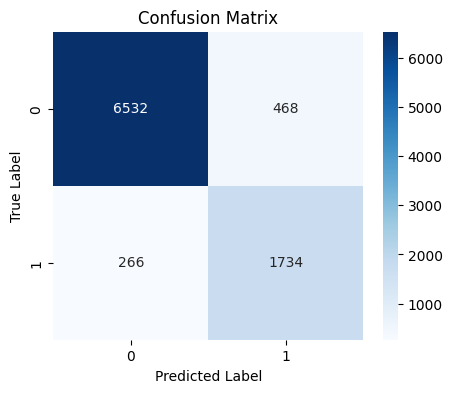

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()



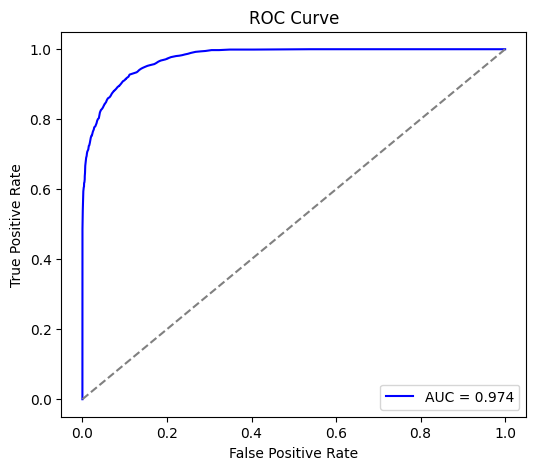

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color="blue", label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


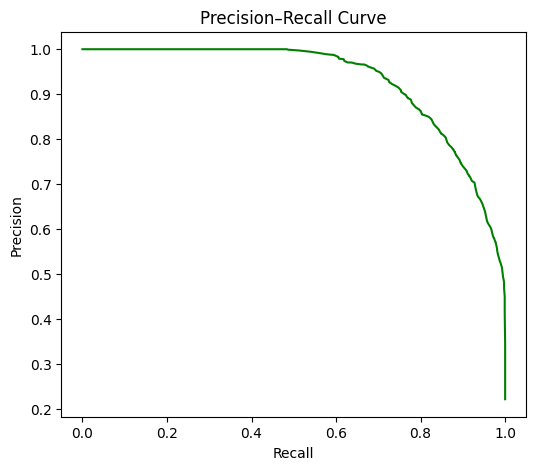

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, color="green")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.show()


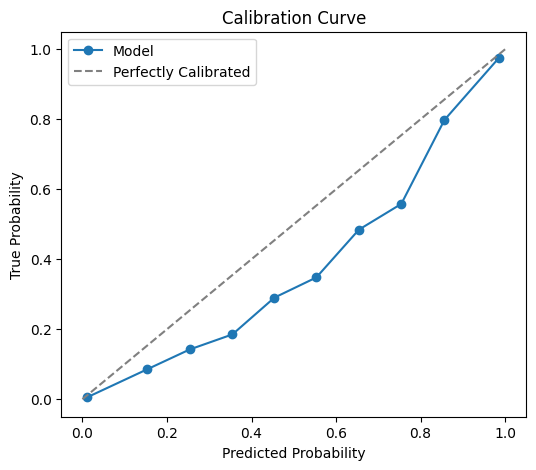

In [ ]:
from sklearn.calibration import calibration_curve

# Compute calibration values
prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10)

# Plot calibration curve
plt.figure(figsize=(6,5))
plt.plot(prob_pred, prob_true, marker='o', label="Model")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Perfectly Calibrated")
plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.title("Calibration Curve")
plt.legend()
plt.show()

##  Final Model Results (Test Set)

| Metric          | Value  | Interpretation                                                          |
| --------------- | ------ | ----------------------------------------------------------------------- |
| **Accuracy**    | 0.9184 | The model correctly classifies about **91.8% of all cases**.            |
| **Precision**   | 0.7875 | Of all cases predicted as positive, **78.7% were actually positive**.   |
| **Recall**      | 0.8670 | The model correctly identifies **86.7% of the actual positive cases**.  |
| **F1-score**    | 0.8253 | Shows a good balance between precision and recall.                      |
| **AUC**         | 0.9745 | Excellent ability to distinguish between positive and negative classes. |
| **Specificity** | 0.9331 | The model correctly identifies **93.3% of the negative cases**.         |


- Interpretation for Your Project

High AUC (0.974)
→ The model is very strong at separating positive and negative cases.

High Specificity (0.933)
→ Very important because your project prioritizes negative cases.
→ Minimizes false positives.

F1-score and Precision slightly lower than Recall
→ Indicates the model prioritizes detecting positive cases while maintaining reasonable precision.

-  Summary

The test set performance closely matches the cross-validation results, indicating the model is stable and reliable.
Overall, the metrics show the model handles both positive and negative cases well, with special attention to reducing errors in the negative class.

#  Save And Load pipline

In [ ]:
import joblib
import json
import os
from datetime import datetime

# Create a directory to store experiment runs
os.makedirs("experiments", exist_ok=True)

# store metadata for one pipeline experiment
experiment_metadata = {
    "experiment_name": "loan__states_v1",
    "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "model_type": "RandomForestClassifier",
    "parameters": pipe.named_steps["model"].get_params(),
    "accuracy": pipe.score(x, y),
    "random_state": 42
}

# Save pipeline and metadata
joblib.dump(pipe, "experiments/pipeline_v1.pkl")

with open("experiments/metadata_v1.json", "w") as f:
    json.dump(experiment_metadata, f, indent=4)

print("Experiment saved successfully.")


Experiment saved successfully.


In [ ]:
# Load the saved pipeline
pipe = joblib.load("experiments/pipeline_v1.pkl")

# Load experiment metadata
with open("experiments/metadata_v1.json") as f:
    loaded_metadata = json.load(f)

print("Loaded Experiment Metadata:")
print(json.dumps(loaded_metadata, indent=4))

# Use loaded pipeline on new data
print("Predictions on new data:", pipe.predict(x[:3]))


Loaded Experiment Metadata:
{
    "experiment_name": "loan__states_v1",
    "timestamp": "2025-12-16 15:24:38",
    "model_type": "RandomForestClassifier",
    "parameters": {
        "bootstrap": true,
        "ccp_alpha": 0.0,
        "class_weight": null,
        "criterion": "gini",
        "max_depth": null,
        "max_features": "sqrt",
        "max_leaf_nodes": null,
        "max_samples": null,
        "min_impurity_decrease": 0.0,
        "min_samples_leaf": 1,
        "min_samples_split": 2,
        "min_weight_fraction_leaf": 0.0,
        "monotonic_cst": null,
        "n_estimators": 100,
        "n_jobs": null,
        "oob_score": false,
        "random_state": 42,
        "verbose": 0,
        "warm_start": false
    },
    "accuracy": 0.9823111111111111,
    "random_state": 42
}
Predictions on new data: [1 0 1]


# user_input

In [ ]:

required_columns = [
    "person_age",
    "loan_amnt",
    "person_income",
    "loan_intent",
    "loan_int_rate",
    "previous_loan_defaults_on_file",
    "person_home_ownership"
]

questions = {
    "person_age": "Enter your age (years): ",
    "loan_amnt": "Enter loan amount: ",
    "person_income": "Enter your amount income: ",
    "loan_intent": "Enter loan intent (DEBTCONSOLIDATION, MEDICAL, HOMEIMPROVEMENT, PERSONAL, EDUCATION, VENTURE): ",
    "loan_int_rate": "Enter loan interest rate (e.g., 0.12 for 12%): ",
    "previous_loan_defaults_on_file": "Previous defaults? (Yes/No): ",
    "person_home_ownership": "Home ownership status? (RENT, MORTGAGE, OWN): "
}

while True:
    user_continue_option = input("Do you want to continue? (enter -1 to exit, 1 to continue): ").strip()
    if user_continue_option == "-1":
        break
    elif user_continue_option != "1":
        print("Please enter a valid option.")
        continue

    user_data = {}

    for col in required_columns:
        while True:
            val = input(questions[col]).strip()
            if val == "":
                print("This field is required. Please enter a value.")
                continue

            # numeric features
            if col in ["person_age", "loan_amnt", "person_income", "loan_int_rate"]:
                try:
                    user_data[col] = float(val)
                    break
                except ValueError:
                    print("Please enter a valid number.")


            elif col == "previous_loan_defaults_on_file":
                if val.upper() in ["YES", "NO"]:
                    user_data[col] = "Yes" if val.upper() == "YES" else "No"
                    break
                else:
                    print("Please enter Yes or No.")

            # categorical features
            elif col in ["loan_intent", "person_home_ownership"]:
                user_data[col] = val.upper()
                break

    # convert to DataFrame
    new_data = pd.DataFrame([user_data])

    # make prediction
    predictions = pipe.predict(new_data)
    probabilities = pipe.predict_proba(new_data)[:, 1]

    for i, p in enumerate(predictions):
        status = "Repaid" if p == 1 else "Defaulted"
        print(f"Customer: Predicted = {status}, Probability of Repayment = {probabilities[i]:.2f}")

    print("\n--- Next Customer ---\n")



Do you want to continue? (enter -1 to exit, 1 to continue): 1
Enter your age (years): 22
Enter loan amount: 5000
Enter your amount income: 800
Enter loan intent (DEBTCONSOLIDATION, MEDICAL, HOMEIMPROVEMENT, PERSONAL, EDUCATION, VENTURE): PERSONAL
Enter loan interest rate (e.g., 0.12 for 12%): 0.12
Previous defaults? (Yes/No): No
Home ownership status? (RENT, MORTGAGE, OWN): OWN
Customer: Predicted = Repaid, Probability of Repayment = 0.77

--- Next Customer ---

Do you want to continue? (enter -1 to exit, 1 to continue): 1
Enter your age (years): 26
Enter loan amount: 10000
Enter your amount income: 900
Enter loan intent (DEBTCONSOLIDATION, MEDICAL, HOMEIMPROVEMENT, PERSONAL, EDUCATION, VENTURE): MEDICAL
Enter loan interest rate (e.g., 0.12 for 12%): 0.10
Previous defaults? (Yes/No): No
Home ownership status? (RENT, MORTGAGE, OWN): OWN
Customer: Predicted = Repaid, Probability of Repayment = 0.75

--- Next Customer ---

Do you want to continue? (enter -1 to exit, 1 to continue): -1
